# fSim gate simulation

here we simulate an fSim gate, focusing on the unitary that is being performed when we play a particular sequence of pulses. We start with the Hamiltonian:

$$
H = \sum_{i=1,2} \left( \omega_i a_i^\dagger a_i + \frac{\eta}{2}a^{\dagger 2}_i a^2_i \right) \\
+ g(t)(a_1^\dagger a_2 + a_2^\dagger a_1)
$$

(open question: how does this get translated to sigma_x sigma_x etc. operators?)

and move to the interaction picture with the Hamiltonian $H_0 = \frac{\omega_1+\omega_2}{2} (a_1^\dagger a_1 + a_2^\dagger a_2$). After doing this transformation we get the Hamiltonian:

$$
H =
\begin{pmatrix}
-\Delta/2 & g & 0 & 0 & 0 \\
g & \Delta/2 & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{2}g & \sqrt{2}g \\
0 & 0 & \sqrt{2}g & -\Delta + \eta  & 0\\
0 & 0 & \sqrt{2}g & 0 & \Delta + \eta
\end{pmatrix}
$$

We want to investigate the unitary that stems from this Hamiltonian for different times and initial states.

In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt

In [2]:

Nh = 2

omega1 = 0#5  # GHz
omega2 = 6  # GHz
Delta = omega2 - omega1
omega_av = (omega1 + omega2) / 2
eta = 0.3  # GHz

a = qp.destroy(Nh)
I = qp.qeye(Nh)

a1 = qp.tensor([a, I])
a2 = qp.tensor([I, a])

# transfomration to rotating frame Hamiltonian
H00 = omega_av * (a1 * a1.dag() + a2 * a2.dag())

# static part of interaction Hamiltonian
H01 = (Delta/2)*(a2.dag()*a2-a1.dag()*a1) + \
     0#(eta/2)*(a1.dag()**2*a1**2 + a2.dag()**2*a2**2) 

# dynamic coupling interaction operators
H10 = a1.dag() * a2 + a2.dag() * a1

# dynamic detuning operators
Hz1 = a2.dag()*a2 - a1.dag()*a1



In [3]:
H01

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  3.  0.  0.]
 [ 0.  0. -3.  0.]
 [ 0.  0.  0.  0.]]

In [4]:
# solve schrodinger equation with initial state 00 and pi/2 pulse on qubit 1
tvec = np.linspace(0, 99.8, 500)
psi0 = qp.fock([Nh, Nh], [0, 0])

# time dependent functions
def g(t, *args):
    return 0


def detun(t, *args):
    return 0


def q2_drive(t, *args):  # this is the baseband signal
    if 10 < t and t < 20:
        return np.pi * 0.1
    else:
        return 0


def q1_drive(t, *args):  # this is the baseband signal
    if 10 < t and t < 20:
        return np.pi * 0.1
    else:
        return 0


def a1_dr(t, *args):
    return q1_drive(t, *args) * np.exp(-1j *(Delta/2) * t)


def a1d_dr(t, *args):
    return q1_drive(t, *args) * np.exp(1j * (Delta/2) * t)


def a2_dr(t, *args):
    return q2_drive(t, *args) * np.exp(-1j * (-Delta/2) * t)


def a2d_dr(t, *args):
    return q2_drive(t, *args) * np.exp(1j * (-Delta/2) * t)


H = [H01,
     [H10, g],
     [Hz1, detun],
     [a1, a1_dr],
     [a1.dag(), a1d_dr],
     [a2, a2_dr],
     [a2.dag(), a2d_dr],
    ]

sol = qp.sesolve(H, psi0, tvec, e_ops = [a1.dag()*a1, a2.dag()*a2], options=qp.Options(max_step=1))

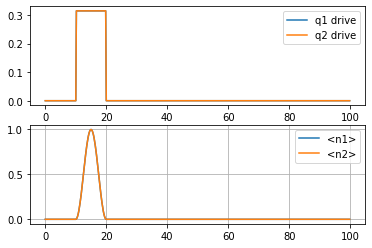

In [5]:
sol.expect[0]
fig, ax = plt.subplots(2, 1)
axn = ax[0]
axn.plot(sol.times, [q1_drive(t) for t in sol.times], label='q1 drive')
axn.plot(sol.times, [q2_drive(t) for t in sol.times], label='q2 drive')
axn.legend()
axn = ax[1]
axn.plot(sol.times, sol.expect[0], label='<n1>')
axn.plot(sol.times, sol.expect[1], label='<n2>')
plt.legend()
axn.grid('minor')